# Watermarking custom audio

[[`arXiv`](https://arxiv.org/abs/2401.17264)]
[[`GitHub`](https://github.com/facebookresearch/audioseal)]

This notebook shows a minimal example how to watermark a custom audio, for example your own recorded voice. This notebook aims to run in Google Collab. Make sure you get familiar with the APIs of AudioSeal, for example using [Getting Started notebook](./Getting_started.ipynb)

## Installation

In [13]:
#@title Install requirements
!pip install torchaudio
!pip install matplotlib
!pip install audioseal # Ensure this matches the actual package name for AudioSeal
!pip install ffmpeg-python

In [15]:
import io
import ffmpeg
import IPython.display as ipd
from google.colab.output import eval_js

from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchaudio

from audioseal import AudioSeal

In [16]:
def plot_waveform_and_specgram(waveform, sample_rate, title):
    waveform = waveform.squeeze().detach().cpu().numpy()

    num_frames = waveform.shape[-1]
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(time_axis, waveform, linewidth=1)
    ax1.grid(True)
    ax2.specgram(waveform, Fs=sample_rate)

    figure.suptitle(f"{title} - Waveform and specgram")
    plt.show()


def play_audio(waveform, sample_rate):
    if waveform.dim() > 2:
        waveform = waveform.squeeze(0)
    waveform = waveform.detach().cpu().numpy()

    num_channels, *_ = waveform.shape
    if num_channels == 1:
        ipd.display(ipd.Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        ipd.display(ipd.Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [17]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(ipd.HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

## Record your audio

In [18]:
recorded, sr = get_audio()

# Convert audio from list of int16 to a normalized tensor
audio = torch.tensor(recorded).float() / 32768.0
print(audio.shape)

torch.Size([397696])


## Generator

To watermark an audio, we simply load the watermarking generator from the hub:

In [61]:
text = "OK"
binary_string = ''.join(f"{ord(c):08b}" for c in text)  # '0100111101001011'
bit_list = [int(bit) for bit in binary_string]

model = AudioSeal.load_generator("audioseal_wm_16bits")

# We add the batch dimension to the single audio to mimic the batch watermarking
audios = audio.unsqueeze(0).unsqueeze(0)  # b=1 c=1 t

watermark = model.get_watermark(audios, sample_rate=sr)
# watermarked_audio = audios + watermark

# Alternatively, you can also call forward() function directly with different tune-down / tune-up rate
watermarked_audio = model(audios, sample_rate=sr, alpha=1)

# You can also watermark with a secret message
# secret_mesage = torch.randint(0, 2, (1, 16), dtype=torch.int32)
secret_message = torch.tensor([bit_list], dtype=torch.int32)
# secret_message = torch.tensor([[int(b) for b in bit_string]], dtype=torch.int32)
watermarked_audio = model(audios, sample_rate=sr, message=secret_message, alpha=1)


We can see that the watermarked audio has preserved almost the same spectrogram and contents as the original one

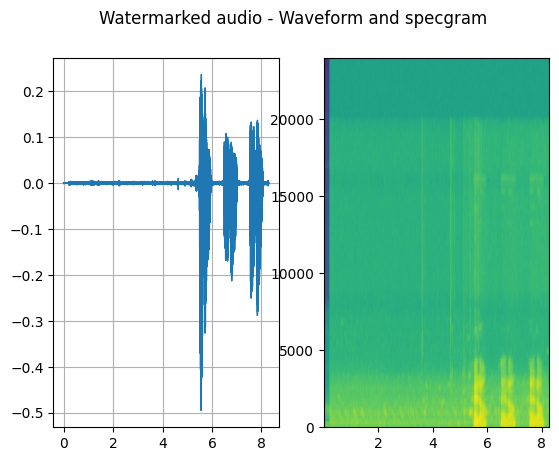

In [58]:
plot_waveform_and_specgram(watermarked_audio.squeeze(), sr, title="Watermarked audio")

In [52]:
play_audio(watermarked_audio, sr)

## Detector

To detect the watermarks from an audio, we load the separate detector model and can do one of the following:

### Basic usage: Call `detect_watermark()`

This results in a tuple of form `Tuple(float, Tensor)`, where the first value indicates the probability of the audio being watermarked (the higher, the more likely), and the second value is the decoded message that is embeded by the generator. If the audio is unwatermarked (low first value), the decoded message will be just some random bits.

Note that due to the stochastic nature of the detector, the decoded message and the secret message might miss by 1 bit, so depending on the user's need, the detection might be called multiple times to get an averaged decoded message.

In [62]:
detector = AudioSeal.load_detector(("audioseal_detector_16bits"))

result, message = detector.detect_watermark(watermarked_audio, sample_rate=sr, message_threshold=0.5)

print(f"\nThis is likely a watermarked audio. WM probability: {result}")

# Run on an unwatermarked audio
result2, message2 = detector.detect_watermark(audios, sample_rate=sr, message_threshold=0.5)
print(f"This is likely an unwatermarked audio. WM probability: {result2}")



This is likely a watermarked audio. WM probability: 1.0
This is likely an unwatermarked audio. WM probability: 0.0


In [63]:
message

tensor([[0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]], dtype=torch.int32)

`message_threshold` indicates the threshold in which the detector will convert the stochastic messages (with probability between 0 and 1) into the n-bit binary format. In most of the case, the generator generates an unbiased message from the secret, so `0.5` is a reasonable choice (so in the above example, value > 0.5 means 1 and value < 0.5 means 0).


### Advanced usage: Call `forward()`

The detector can also be called directly as a Torch module. This will return 2 tensors:
- The first tensor of size `batch x 2 x frames` indicates the probability of each frame being watermarked (positive or negative). So t[:, 0, :] corresponds to the negative probability and t[:, 1, :] corresponds to the positive probability
- The second tensor of size `batch x n_bits` corresponds to the message detected from the audio. It indicates the probability for each bit to be 1. In case of unwatermarked audios, this tensor is random

In [24]:
pred_prob, message_prob = detector(watermarked_audio, sample_rate=sr)
pred_prob[:, 1, :]

tensor([[0.9998, 0.9998, 0.9998,  ..., 0.9987, 0.9987, 0.9986]],
       grad_fn=<SliceBackward0>)

In [25]:
message_prob

tensor([[0.7769, 0.2386, 0.7904, 0.8193, 0.1624, 0.7290, 0.7739, 0.7358, 0.7764,
         0.2261, 0.7562, 0.7849, 0.8095, 0.7585, 0.8250, 0.2573]],
       grad_fn=<SigmoidBackward0>)

### Robustness against attacks

We can evaluate the robustness of the detector against some attacks. For this purpose, we will perform some simple attacks: Pink noise, highpass filter, compression in different formats. For the full list of attacks, please refer to our paper.


#### Pink noise attack

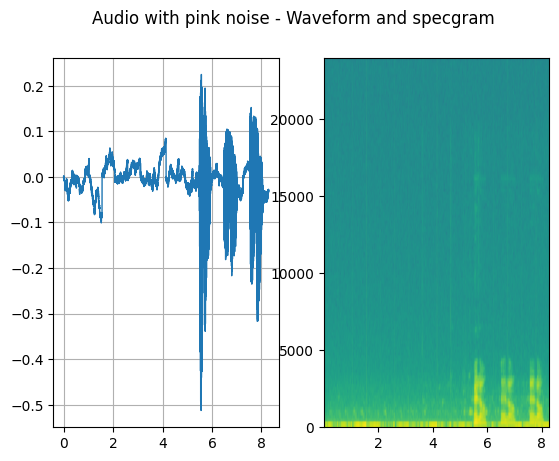

0.9775883555412292


In [26]:

from attacks import AudioEffects as af

pink_noised_audio = af.pink_noise(watermarked_audio, noise_std=0.1)
plot_waveform_and_specgram(pink_noised_audio, sample_rate=sr, title="Audio with pink noise")
result, message = detector.detect_watermark(pink_noised_audio, sample_rate=sr)
print(result)

#### Lowpass filter

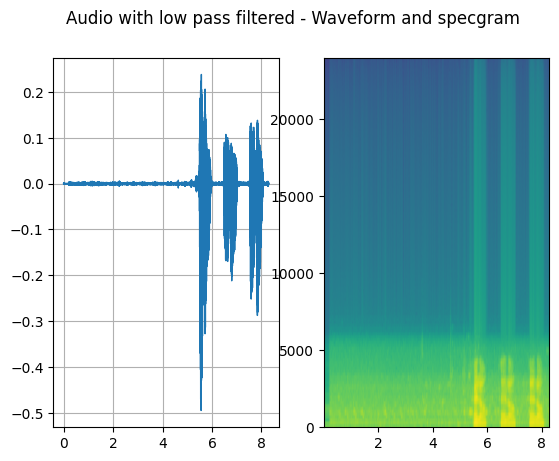

1.0


In [27]:
lowpass_filtered = af.lowpass_filter(watermarked_audio, cutoff_freq=5000, sample_rate=sr)
plot_waveform_and_specgram(lowpass_filtered, sample_rate=sr, title="Audio with low pass filtered")
result, message = detector.detect_watermark(lowpass_filtered, sample_rate=sr)
print(result)